In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import matplotlib.pyplot as plt
import SolveLinSys
from utilities import compute_derivatives_2d, find_nearest_value
from numba import njit

Equation:

\begin{align*}
0 = \max_{e} \min_{h_2} & -\delta \phi(y, z_2) + \delta \eta \log e - \delta(1-\eta) \left(\gamma_1 y z_2 + \frac{\gamma_2}{2}y^2z_2^2 \right) + \xi_m\frac{(h_2)^2}{2} + \frac{\partial \phi}{\partial y}(y, z_2) e  \\
& + \left[\frac{\partial \phi}{\partial z_2}(y, z_2)\right]\left[-\rho (z_2 -\mu_2) + \sqrt{z_2} \sigma_2 h_2\right] + \left[\frac{\partial^2 \phi}{\partial(z_2)^2}(y, z_2)\right]\left(\frac{z_2|\sigma_2|^2}{2}\right)
\end{align*}

FOC of $h_2$ gives : 

$$
h_2^* = -\frac{\left[\frac{\partial \phi}{\partial z_2}(y, z_2)\right]\sqrt{z_2}\sigma_2}{\xi_m}
$$

FOC of $e$ gives :

$$
e^* = -\frac{\delta \eta}{\frac{\partial \phi}{\partial y}(y, z_2)}
$$

In [62]:
def false_transient_one_iteration(stateSpace, A, B_z, B_y, C_zz, C_yy, D, v0, ε=.3, tol=-10):
    A = A.reshape(-1, 1, order='F')
    B = np.hstack([B_z.reshape(-1, 1, order='F'), B_y.reshape(-1, 1, order='F')])
    C = np.hstack([C_zz.reshape(-1, 1, order='F'), C_yy.reshape(-1, 1, order='F')])
    D = D.reshape(-1, 1, order='F')
    v0 = v0.reshape(-1, 1, order='F')
    out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0, ε, tol)
    return out


def false_transient(z_grid, y_grid, model_paras=(), v0=None, ϵ=.5, tol=1e-8, max_iter=10_000):
    η, ξ_m, δ, η, μ_2, ρ, σ_2, γ_1, γ_2, γ_2p, γ_bar = model_paras

    Δ_z = z_grid[1] - z_grid[0]
    Δ_y = y_grid[1] - y_grid[0]
    (z_mat, y_mat) = np.meshgrid(z_grid, y_grid, indexing = 'ij')
    stateSpace = np.hstack([z_mat.reshape(-1, 1, order='F'), y_mat.reshape(-1, 1, order='F')])

    if v0 is None:
        v0 = -δ*η*y_mat

    count = 1
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()
        v0_dz = compute_derivatives_2d(v0, 0, 1, Δ_z)
        v0_dzz = compute_derivatives_2d(v0, 0, 2, Δ_z)
        v0_dy = compute_derivatives_2d(v0, 1, 1, Δ_y)

        e = -δ*η / v0_dy
        e[e<=0] = 1e-10
        h = -v0_dz*np.sqrt(z_mat)*σ_2 / ξ_m

        A = np.ones_like(z_mat)*(-δ)
        B_z = -ρ*(z_mat - μ_2) + np.sqrt(z_mat)*σ_2*h
        B_y = e
        C_zz = z_mat*σ_2**2/2
        C_yy = np.zeros_like(z_mat)
        D = δ*η*np.log(e) - δ*(1-η)*(γ_1*y_mat*z_mat+γ_2/2.*y_mat**2*z_mat**2
                                     +γ_2p/2.*(y_mat*z_mat>γ_bar)*(y_mat*z_mat-γ_bar)**2) + ξ_m*h**2/2

        res = false_transient_one_iteration(stateSpace, A, B_z, B_y, C_zz, C_yy, D, v0, ϵ) # CG tol = 1e-10
        v0 = res[2].reshape(v0.shape, order = "F")

        rhs_error = A*v0 + B_z*v0_dz + B_y*v0_dy + C_zz*v0_dzz + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error

        print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))
        count += 1
    print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))
    return v0, e, h

In [63]:
# Model parameters
η = .032
ξ_m = .00256
# ξ_m = 1000.
δ = .01
# Z process
μ_2 = 1.86/1000.
ρ = 0.9
σ_2 = np.sqrt(2*ρ/10416.29)/2
# Damage setting
γ_1 = 1.7675/10000
γ_2 = 0.0022*2
# γ_2p = 0.
γ_2p = 0.0197*2
γ_bar = 2.

pde_paras = (η, ξ_m, δ, η, μ_2, ρ, σ_2, γ_1, γ_2, γ_2p, γ_bar)

# Capital and z parameters
α_k = -0.043
β_k = 0.04
σ_k = np.array([0.477*2, 0])/100.
β_z = 0.014*4
σ_z = np.array([0.011*2, 0.025*2])
α = 0.115
ioverk = 0.09
κ = 6.667

# Grid setting
n_z = 50
z_min = np.max([μ_2 - 3*np.sqrt(σ_2**2*μ_2/(2*ρ)), 1e-9])
z_max = μ_2 + 3*np.sqrt(σ_2**2*μ_2/(2*ρ))
z_grid = np.linspace(z_min, z_max, n_z)

n_y = 50
y_min = 1e-2
y_max = 3000.
y_grid = np.linspace(y_min, y_max, n_y)

In [64]:
ϕ_grid, e_grid, h_grid = false_transient(z_grid, y_grid, model_paras=pde_paras, v0=None, ϵ=.5, tol=1e-8, max_iter=10_000)

Iteration 1: LHS Error: 0.007792421466964683; RHS Error 0.00840937697590422
Iteration 2: LHS Error: 0.007228066282449985; RHS Error 0.0077451691394229746
Iteration 3: LHS Error: 0.006767808492439631; RHS Error 0.0071867743819910524
Iteration 4: LHS Error: 0.006399549966524587; RHS Error 0.0067311181655253455
Iteration 5: LHS Error: 0.0061081203638158055; RHS Error 0.006366170658487729
Iteration 6: LHS Error: 0.0058855753944404565; RHS Error 0.006077055487287903
Iteration 7: LHS Error: 0.0057271666559288725; RHS Error 0.005859094054814762
Iteration 8: LHS Error: 0.005609386392870119; RHS Error 0.005705476105997011
Iteration 9: LHS Error: 0.005520356625071443; RHS Error 0.0055907592776947975
Iteration 10: LHS Error: 0.00544885930206962; RHS Error 0.005504101717130345
Iteration 11: LHS Error: 0.005391555925886582; RHS Error 0.005433766516654127
Iteration 12: LHS Error: 0.005342625102515486; RHS Error 0.00537773546266628
Iteration 13: LHS Error: 0.005299877429593813; RHS Error 0.0053297781

Iteration 108: LHS Error: 0.0032721897716996295; RHS Error 0.0032889545608608163
Iteration 109: LHS Error: 0.003255901885197643; RHS Error 0.00327266607441747
Iteration 110: LHS Error: 0.003239694695071682; RHS Error 0.003256483440350968
Iteration 111: LHS Error: 0.0032235677920904315; RHS Error 0.0032403809633952682
Iteration 112: LHS Error: 0.0032075207612922707; RHS Error 0.003224358222186053
Iteration 113: LHS Error: 0.0031915532438557825; RHS Error 0.0032084148735165587
Iteration 114: LHS Error: 0.003175664836505332; RHS Error 0.0031925505161377555
Iteration 115: LHS Error: 0.0031598551478506653; RHS Error 0.003176764752119291
Iteration 116: LHS Error: 0.0031441237711393732; RHS Error 0.0031610571905533297
Iteration 117: LHS Error: 0.0031284703561660354; RHS Error 0.003145427447472647
Iteration 118: LHS Error: 0.003112894488163098; RHS Error 0.0031298751165675254
Iteration 119: LHS Error: 0.0030973957844342426; RHS Error 0.0031143998795655718
Iteration 120: LHS Error: 0.0030819738

Iteration 215: LHS Error: 0.0019173161016112772; RHS Error 0.001935926035777378
Iteration 216: LHS Error: 0.0019077755091909676; RHS Error 0.0019263730325956596
Iteration 217: LHS Error: 0.0018982821642364867; RHS Error 0.0019168675004896905
Iteration 218: LHS Error: 0.0018888358374066216; RHS Error 0.0019074091800123725
Iteration 219: LHS Error: 0.0018794362942097242; RHS Error 0.0018979978450182056
Iteration 220: LHS Error: 0.0018700833057196942; RHS Error 0.0018886332660132575
Iteration 221: LHS Error: 0.0018607766351567134; RHS Error 0.0018793151768274376
Iteration 222: LHS Error: 0.0018515160669950737; RHS Error 0.001870043387189609
Iteration 223: LHS Error: 0.0018423013615355144; RHS Error 0.0018608176824003659
Iteration 224: LHS Error: 0.0018331322962337193; RHS Error 0.0018516377861150916
Iteration 225: LHS Error: 0.001824008653029452; RHS Error 0.0018425034987791789
Iteration 226: LHS Error: 0.0018149302101571063; RHS Error 0.001833414605561936
Iteration 227: LHS Error: 0.0018

Iteration 317: LHS Error: 0.001152007633598795; RHS Error 0.0011710047342380248
Iteration 318: LHS Error: 0.0011462617860960034; RHS Error 0.0011652668877426648
Iteration 319: LHS Error: 0.0011405444702572431; RHS Error 0.0011595576254995821
Iteration 320: LHS Error: 0.0011348555548271744; RHS Error 0.0011538766871113152
Iteration 321: LHS Error: 0.0011291948840355115; RHS Error 0.001148223945035889
Iteration 322: LHS Error: 0.0011235622235035159; RHS Error 0.0011425992582044101
Iteration 323: LHS Error: 0.0011179578286198977; RHS Error 0.0011370025537077364
Iteration 324: LHS Error: 0.0011123809362793002; RHS Error 0.0011314334767913972
Iteration 325: LHS Error: 0.0011068319129744486; RHS Error 0.001125892246798627
Iteration 326: LHS Error: 0.001101310739377137; RHS Error 0.0011203783970529574
Iteration 327: LHS Error: 0.001095816574968267; RHS Error 0.001114891909013693
Iteration 328: LHS Error: 0.0010903507557831205; RHS Error 0.0011094328558698204
Iteration 329: LHS Error: 0.001084

Iteration 420: LHS Error: 0.0006887600592979659; RHS Error 0.0007076352600105721
Iteration 421: LHS Error: 0.0006853261729828919; RHS Error 0.0007042058968935316
Iteration 422: LHS Error: 0.0006819091471105265; RHS Error 0.0007007935628126713
Iteration 423: LHS Error: 0.0006785091382391917; RHS Error 0.0006973981158146484
Iteration 424: LHS Error: 0.0006751259485318073; RHS Error 0.0006940195392089447
Iteration 425: LHS Error: 0.0006717595146545907; RHS Error 0.0006906576934218384
Iteration 426: LHS Error: 0.0006684098870048949; RHS Error 0.0006873125870872588
Iteration 427: LHS Error: 0.0006650770250555826; RHS Error 0.000683984079123609
Iteration 428: LHS Error: 0.0006617604544911782; RHS Error 0.0006806721211268296
Iteration 429: LHS Error: 0.0006584606250353842; RHS Error 0.0006773765370178856
Iteration 430: LHS Error: 0.0006551769914403538; RHS Error 0.0006740973719393444
Iteration 431: LHS Error: 0.0006519096752279907; RHS Error 0.0006708344375279231
Iteration 432: LHS Error: 0.0

Iteration 522: LHS Error: 0.00041386500893059175; RHS Error 0.00043267642820600473
Iteration 523: LHS Error: 0.0004117996170308613; RHS Error 0.0004306132286902936
Iteration 524: LHS Error: 0.00040974005773608546; RHS Error 0.00042856023553094254
Iteration 525: LHS Error: 0.00040770432549841473; RHS Error 0.0004265175022928479
Iteration 526: LHS Error: 0.00040566535660774283; RHS Error 0.000424484985900276
Iteration 527: LHS Error: 0.00040364314782553867; RHS Error 0.00042246249431957564
Iteration 528: LHS Error: 0.0004016395741501255; RHS Error 0.0004204501946360494
Iteration 529: LHS Error: 0.0003996352348086263; RHS Error 0.00041844784315428165
Iteration 530: LHS Error: 0.00039763678991833196; RHS Error 0.0004164553938006395
Iteration 531: LHS Error: 0.0003956607539674084; RHS Error 0.00041447291599849134
Iteration 532: LHS Error: 0.00039368198838296564; RHS Error 0.0004125003569550921
Iteration 533: LHS Error: 0.0003917259393962924; RHS Error 0.00041053753633474397
Iteration 534: L

Iteration 623: LHS Error: 0.0002499211509591204; RHS Error 0.00026859598025906804
Iteration 624: LHS Error: 0.0002486756340769336; RHS Error 0.00026735028062850873
Iteration 625: LHS Error: 0.00024743614791150614; RHS Error 0.00026611046803782016
Iteration 626: LHS Error: 0.00024620296502475547; RHS Error 0.00026487673186842875
Iteration 627: LHS Error: 0.0002449759631761306; RHS Error 0.0002636494634482155
Iteration 628: LHS Error: 0.0002437556066338109; RHS Error 0.0002624282546940353
Iteration 629: LHS Error: 0.00024254053267624975; RHS Error 0.0002612133068350723
Iteration 630: LHS Error: 0.0002413314674907796; RHS Error 0.0002600040442905344
Iteration 631: LHS Error: 0.0002401285589619384; RHS Error 0.00025880076915303554
Iteration 632: LHS Error: 0.00023893171952965586; RHS Error 0.0002576037651099571
Iteration 633: LHS Error: 0.000237741261316482; RHS Error 0.0002564127591473881
Iteration 634: LHS Error: 0.00023655629370650244; RHS Error 0.0002552278055811452
Iteration 635: LHS 

Iteration 726: LHS Error: 0.00014942544595725193; RHS Error 0.00016809485734461862
Iteration 727: LHS Error: 0.00014868077783236622; RHS Error 0.00016735271929144016
Iteration 728: LHS Error: 0.00014794008184881857; RHS Error 0.00016661432931737712
Iteration 729: LHS Error: 0.00014720281302160743; RHS Error 0.00016587965112403274
Iteration 730: LHS Error: 0.00014646943537249824; RHS Error 0.00016514874151171742
Iteration 731: LHS Error: 0.00014573930101885457; RHS Error 0.00016442144467292168
Iteration 732: LHS Error: 0.00014501735782523895; RHS Error 0.00016369768662033603
Iteration 733: LHS Error: 0.00014429045583802536; RHS Error 0.00016297772006492378
Iteration 734: LHS Error: 0.00014357109219204078; RHS Error 0.0001622611473795334
Iteration 735: LHS Error: 0.00014285550944198588; RHS Error 0.0001615482234560973
Iteration 736: LHS Error: 0.0001421437061454034; RHS Error 0.00016083888898455156
Iteration 737: LHS Error: 0.00014143507607405903; RHS Error 0.00016013320863710414
Iterati

Iteration 826: LHS Error: 9.069910901310374e-05; RHS Error 0.00010985035139738129
Iteration 827: LHS Error: 9.024471855767491e-05; RHS Error 0.00010940671801456517
Iteration 828: LHS Error: 8.979321195401457e-05; RHS Error 0.00010896487970414495
Iteration 829: LHS Error: 8.934251717429564e-05; RHS Error 0.00010852543742393604
Iteration 830: LHS Error: 8.8897155983092e-05; RHS Error 0.00010808807471590935
Iteration 831: LHS Error: 8.845991845074508e-05; RHS Error 0.00010765487643575621
Iteration 832: LHS Error: 8.801735222713214e-05; RHS Error 0.00010722548796900295
Iteration 833: LHS Error: 8.757733450120986e-05; RHS Error 0.00010679838190445594
Iteration 834: LHS Error: 8.714001552212469e-05; RHS Error 0.00010637333771931897
Iteration 835: LHS Error: 8.670520334869147e-05; RHS Error 0.00010595041662133818
Iteration 836: LHS Error: 8.627274406863839e-05; RHS Error 0.00010552962556538393
Iteration 837: LHS Error: 8.584254727339591e-05; RHS Error 0.00010511095764176954
Iteration 838: LHS

Iteration 930: LHS Error: 5.3955235281955005e-05; RHS Error 7.428773182475751e-05
Iteration 931: LHS Error: 5.368632058855294e-05; RHS Error 7.402982926544796e-05
Iteration 932: LHS Error: 5.341874315822892e-05; RHS Error 7.377323559868841e-05
Iteration 933: LHS Error: 5.315248235326919e-05; RHS Error 7.351793155284403e-05
Iteration 934: LHS Error: 5.288757643967523e-05; RHS Error 7.326391588860926e-05
Iteration 935: LHS Error: 5.262393166532986e-05; RHS Error 7.301117282700791e-05
Iteration 936: LHS Error: 5.236162405442002e-05; RHS Error 7.275972219433725e-05
Iteration 937: LHS Error: 5.21006154965975e-05; RHS Error 7.250952510685503e-05
Iteration 938: LHS Error: 5.184091102899968e-05; RHS Error 7.226059876346209e-05
Iteration 939: LHS Error: 5.158248590791947e-05; RHS Error 7.201291900655281e-05
Iteration 940: LHS Error: 5.132535047347453e-05; RHS Error 7.176649211085187e-05
Iteration 941: LHS Error: 5.1069492127853167e-05; RHS Error 7.15213119657789e-05
Iteration 942: LHS Error: 5.

Iteration 1034: LHS Error: 3.210167536343844e-05; RHS Error 5.3550559866584056e-05
Iteration 1035: LHS Error: 3.194181816112973e-05; RHS Error 5.3399666798012294e-05
Iteration 1036: LHS Error: 3.178271550477452e-05; RHS Error 5.324963539382588e-05
Iteration 1037: LHS Error: 3.1624631130877656e-05; RHS Error 5.3100382936826607e-05
Iteration 1038: LHS Error: 3.1467141919511166e-05; RHS Error 5.2951756451246885e-05
Iteration 1039: LHS Error: 3.131054349642115e-05; RHS Error 5.2804034425166105e-05
Iteration 1040: LHS Error: 3.1154728762222694e-05; RHS Error 5.2656967116210566e-05
Iteration 1041: LHS Error: 3.0999764281308684e-05; RHS Error 5.251064999545435e-05
Iteration 1042: LHS Error: 3.0845368334253553e-05; RHS Error 5.236503869291906e-05
Iteration 1043: LHS Error: 3.069190239174402e-05; RHS Error 5.222034321143438e-05
Iteration 1044: LHS Error: 3.053914281347936e-05; RHS Error 5.207610261495426e-05
Iteration 1045: LHS Error: 3.038740700495035e-05; RHS Error 5.1932736990497794e-05
Iter

Iteration 1135: LHS Error: 1.9389583472667615e-05; RHS Error 4.1592523525221564e-05
Iteration 1136: LHS Error: 1.9293056255698104e-05; RHS Error 4.150206176821642e-05
Iteration 1137: LHS Error: 1.919701132921392e-05; RHS Error 4.1412054372555506e-05
Iteration 1138: LHS Error: 1.910143838992906e-05; RHS Error 4.132250096485434e-05
Iteration 1139: LHS Error: 1.9006341339417032e-05; RHS Error 4.123340116954724e-05
Iteration 1140: LHS Error: 1.891171692319782e-05; RHS Error 4.1144748311024485e-05
Iteration 1141: LHS Error: 1.8817558392891787e-05; RHS Error 4.105654676180644e-05
Iteration 1142: LHS Error: 1.8723865306491394e-05; RHS Error 4.096878653998793e-05
Iteration 1143: LHS Error: 1.8630640325034697e-05; RHS Error 4.0881470503239116e-05
Iteration 1144: LHS Error: 1.8537873959834084e-05; RHS Error 4.0794596932048634e-05
Iteration 1145: LHS Error: 1.844557039062944e-05; RHS Error 4.0708159885995804e-05
Iteration 1146: LHS Error: 1.8353723610142758e-05; RHS Error 4.062215908697496e-05
It

Iteration 1236: LHS Error: 1.1711149613069516e-05; RHS Error 3.442091872128477e-05
Iteration 1237: LHS Error: 1.1652814352003382e-05; RHS Error 3.43666543338231e-05
Iteration 1238: LHS Error: 1.1594771048145658e-05; RHS Error 3.431265936019133e-05
Iteration 1239: LHS Error: 1.1537010945500414e-05; RHS Error 3.425894968680631e-05
Iteration 1240: LHS Error: 1.1479544556269872e-05; RHS Error 3.4205501718050394e-05
Iteration 1241: LHS Error: 1.1422361774343637e-05; RHS Error 3.4152326366911436e-05
Iteration 1242: LHS Error: 1.1365458514628335e-05; RHS Error 3.409942523032925e-05
Iteration 1243: LHS Error: 1.1308854874825247e-05; RHS Error 3.404678748575817e-05
Iteration 1244: LHS Error: 1.1252500137254318e-05; RHS Error 3.399441992505412e-05
Iteration 1245: LHS Error: 1.119644430852551e-05; RHS Error 3.394230572237821e-05
Iteration 1246: LHS Error: 1.1140675941573308e-05; RHS Error 3.389045475283377e-05
Iteration 1247: LHS Error: 1.1085165247393114e-05; RHS Error 3.383887262683864e-05
Iter

Iteration 1340: LHS Error: 6.9687202012280736e-06; RHS Error 3.0036354575719258e-05
Iteration 1341: LHS Error: 6.933973760669954e-06; RHS Error 3.00047365567271e-05
Iteration 1342: LHS Error: 6.899578567365339e-06; RHS Error 2.9973046905378974e-05
Iteration 1343: LHS Error: 6.865085531188031e-06; RHS Error 2.9941444962509672e-05
Iteration 1344: LHS Error: 6.830994100925913e-06; RHS Error 2.99103008342288e-05
Iteration 1345: LHS Error: 6.796887808857566e-06; RHS Error 2.9879362055059235e-05
Iteration 1346: LHS Error: 6.763151292554781e-06; RHS Error 2.9848252564905367e-05
Iteration 1347: LHS Error: 6.729376912595342e-06; RHS Error 2.9817470004227936e-05
Iteration 1348: LHS Error: 6.696019917207252e-06; RHS Error 2.9786893524819634e-05
Iteration 1349: LHS Error: 6.662635580745313e-06; RHS Error 2.9756537184147023e-05
Iteration 1350: LHS Error: 6.629586421030842e-06; RHS Error 2.9726108948996736e-05
Iteration 1351: LHS Error: 6.59647797801588e-06; RHS Error 2.969576705197667e-05
Iteration

Iteration 1442: LHS Error: 4.188408131933219e-06; RHS Error 2.750166887188505e-05
Iteration 1443: LHS Error: 4.167486298389811e-06; RHS Error 2.7483077047940098e-05
Iteration 1444: LHS Error: 4.1467167164743746e-06; RHS Error 2.7464388821074777e-05
Iteration 1445: LHS Error: 4.126057023323693e-06; RHS Error 2.7445765286385226e-05
Iteration 1446: LHS Error: 4.105499499806875e-06; RHS Error 2.742718647643727e-05
Iteration 1447: LHS Error: 4.0850443146778215e-06; RHS Error 2.74086331362313e-05
Iteration 1448: LHS Error: 4.064690111299507e-06; RHS Error 2.7390124942700575e-05
Iteration 1449: LHS Error: 4.044436564015763e-06; RHS Error 2.7371677779120473e-05
Iteration 1450: LHS Error: 4.0242970988785265e-06; RHS Error 2.7353305722161922e-05
Iteration 1451: LHS Error: 4.007628015834097e-06; RHS Error 2.7335031386326557e-05
Iteration 1452: LHS Error: 3.984402025272726e-06; RHS Error 2.731677486997276e-05
Iteration 1453: LHS Error: 3.964540204556832e-06; RHS Error 2.7298891367010512e-05
Iterat

Iteration 1541: LHS Error: 2.555835746917423e-06; RHS Error 2.6026479439589223e-05
Iteration 1542: LHS Error: 2.5429961385270428e-06; RHS Error 2.6015000790998995e-05
Iteration 1543: LHS Error: 2.5302911727115296e-06; RHS Error 2.600357649689322e-05
Iteration 1544: LHS Error: 2.5178300254585784e-06; RHS Error 2.5992198536376214e-05
Iteration 1545: LHS Error: 2.505239541178428e-06; RHS Error 2.5980895425239373e-05
Iteration 1546: LHS Error: 2.4927495944349065e-06; RHS Error 2.5969651668413386e-05
Iteration 1547: LHS Error: 2.480280142186375e-06; RHS Error 2.5958453101483387e-05
Iteration 1548: LHS Error: 2.467908615841341e-06; RHS Error 2.5947301550821003e-05
Iteration 1549: LHS Error: 2.4557570594968547e-06; RHS Error 2.5936214419214104e-05
Iteration 1550: LHS Error: 2.4434760633601504e-06; RHS Error 2.5925194402565653e-05
Iteration 1551: LHS Error: 2.4312944745946696e-06; RHS Error 2.5914226810764976e-05
Iteration 1552: LHS Error: 2.4192067938633155e-06; RHS Error 2.590330593962788e-0

Iteration 1643: LHS Error: 1.5371962626825608e-06; RHS Error 2.511107218827952e-05
Iteration 1644: LHS Error: 1.5292859229243394e-06; RHS Error 2.510430758260367e-05
Iteration 1645: LHS Error: 1.521057841152862e-06; RHS Error 2.5097530873598845e-05
Iteration 1646: LHS Error: 1.5134458766635772e-06; RHS Error 2.5090855498499914e-05
Iteration 1647: LHS Error: 1.5058723665112295e-06; RHS Error 2.50841975364608e-05
Iteration 1648: LHS Error: 1.4983387272571314e-06; RHS Error 2.5077496667513083e-05
Iteration 1649: LHS Error: 1.4957139152158017e-06; RHS Error 2.5070744131320123e-05
Iteration 1650: LHS Error: 1.4834722979473192e-06; RHS Error 2.506409074009067e-05
Iteration 1651: LHS Error: 1.4797959214871148e-06; RHS Error 2.5057284367809452e-05
Iteration 1652: LHS Error: 1.468753025625491e-06; RHS Error 2.505072551240925e-05
Iteration 1653: LHS Error: 1.4648064905475877e-06; RHS Error 2.504407682473646e-05
Iteration 1654: LHS Error: 1.4541819990734894e-06; RHS Error 2.503762685787843e-05
It

Iteration 1745: LHS Error: 9.235241633549773e-07; RHS Error 2.4563479990283538e-05
Iteration 1746: LHS Error: 9.188998550922756e-07; RHS Error 2.4559444173709267e-05
Iteration 1747: LHS Error: 9.143148131940393e-07; RHS Error 2.4555329961422658e-05
Iteration 1748: LHS Error: 9.09756628260372e-07; RHS Error 2.455129078572757e-05
Iteration 1749: LHS Error: 9.052246879026615e-07; RHS Error 2.454725458524165e-05
Iteration 1750: LHS Error: 9.007159520665886e-07; RHS Error 2.454325170974216e-05
Iteration 1751: LHS Error: 8.962295801814846e-07; RHS Error 2.4539268543258773e-05
Iteration 1752: LHS Error: 8.917674066757919e-07; RHS Error 2.4535296152898003e-05
Iteration 1753: LHS Error: 8.87326191540555e-07; RHS Error 2.4531358337716107e-05
Iteration 1754: LHS Error: 8.829076948296821e-07; RHS Error 2.4527414385555482e-05
Iteration 1755: LHS Error: 8.785119791042406e-07; RHS Error 2.4523522919235726e-05
Iteration 1756: LHS Error: 8.741364788782124e-07; RHS Error 2.4519638209946344e-05
Iteration

Iteration 1848: LHS Error: 5.524239292675759e-07; RHS Error 2.423473193101616e-05
Iteration 1849: LHS Error: 5.496736108223654e-07; RHS Error 2.4232327369461517e-05
Iteration 1850: LHS Error: 5.469377710870527e-07; RHS Error 2.4229925374171023e-05
Iteration 1851: LHS Error: 5.442213938666729e-07; RHS Error 2.4227532798255314e-05
Iteration 1852: LHS Error: 5.415081620364914e-07; RHS Error 2.4225158763130903e-05
Iteration 1853: LHS Error: 5.388094329143722e-07; RHS Error 2.4222775474617856e-05
Iteration 1854: LHS Error: 5.361326559025215e-07; RHS Error 2.4220427179382723e-05
Iteration 1855: LHS Error: 5.334604029627599e-07; RHS Error 2.4218094463037657e-05
Iteration 1856: LHS Error: 5.308955808094873e-07; RHS Error 2.4215747461900166e-05
Iteration 1857: LHS Error: 5.282392654508417e-07; RHS Error 2.421368048137278e-05
Iteration 1858: LHS Error: 5.255524682321044e-07; RHS Error 2.4210996544827873e-05
Iteration 1859: LHS Error: 5.2292695166406e-07; RHS Error 2.4208708830023387e-05
Iteratio

Iteration 1949: LHS Error: 3.3371051268854535e-07; RHS Error 2.4041801081639428e-05
Iteration 1950: LHS Error: 3.320492042990786e-07; RHS Error 2.4040375687765098e-05
Iteration 1951: LHS Error: 3.3039609594748276e-07; RHS Error 2.4038958610810186e-05
Iteration 1952: LHS Error: 3.2875128339743265e-07; RHS Error 2.4037548063172835e-05
Iteration 1953: LHS Error: 3.2711425033277175e-07; RHS Error 2.403614653870127e-05
Iteration 1954: LHS Error: 3.2548563611706216e-07; RHS Error 2.4034748969970062e-05
Iteration 1955: LHS Error: 3.2386539752099486e-07; RHS Error 2.4033360721277845e-05
Iteration 1956: LHS Error: 3.222534830024659e-07; RHS Error 2.4031980455892677e-05
Iteration 1957: LHS Error: 3.206498249211376e-07; RHS Error 2.4030606470238692e-05
Iteration 1958: LHS Error: 3.1905441390950307e-07; RHS Error 2.4029238603224265e-05
Iteration 1959: LHS Error: 3.174658795915275e-07; RHS Error 2.402788060960491e-05
Iteration 1960: LHS Error: 3.1588578951885493e-07; RHS Error 2.4026526123982397e-0

Iteration 2050: LHS Error: 2.0157104306528506e-07; RHS Error 2.392902709525129e-05
Iteration 2051: LHS Error: 2.0056732652484754e-07; RHS Error 2.392818388168797e-05
Iteration 2052: LHS Error: 1.9956822332189983e-07; RHS Error 2.392734589178611e-05
Iteration 2053: LHS Error: 1.9857587660321308e-07; RHS Error 2.392651210086276e-05
Iteration 2054: LHS Error: 1.9758858486873532e-07; RHS Error 2.3925679390220567e-05
Iteration 2055: LHS Error: 1.966050400953323e-07; RHS Error 2.3924856158511962e-05
Iteration 2056: LHS Error: 1.9562697672892426e-07; RHS Error 2.3924032092612567e-05
Iteration 2057: LHS Error: 1.9465389863859706e-07; RHS Error 2.3923215273432673e-05
Iteration 2058: LHS Error: 1.936841911992504e-07; RHS Error 2.39224031427515e-05
Iteration 2059: LHS Error: 1.927209475893754e-07; RHS Error 2.3921595175599008e-05
Iteration 2060: LHS Error: 1.9176080748306568e-07; RHS Error 2.3920788495918922e-05
Iteration 2061: LHS Error: 1.9080679472538442e-07; RHS Error 2.3919986532032348e-05
I

Iteration 2150: LHS Error: 1.2234901113072905e-07; RHS Error 2.386048453456959e-05
Iteration 2151: LHS Error: 1.217402324366068e-07; RHS Error 2.3859986927326853e-05
Iteration 2152: LHS Error: 1.211344847623641e-07; RHS Error 2.3859495403600185e-05
Iteration 2153: LHS Error: 1.205316481622809e-07; RHS Error 2.3859007201316898e-05
Iteration 2154: LHS Error: 1.1993165532908634e-07; RHS Error 2.3858512635079217e-05
Iteration 2155: LHS Error: 1.19335051743108e-07; RHS Error 2.3858028837188687e-05
Iteration 2156: LHS Error: 1.1874141235546087e-07; RHS Error 2.3857550689487567e-05
Iteration 2157: LHS Error: 1.1815016627558794e-07; RHS Error 2.385707477056459e-05
Iteration 2158: LHS Error: 1.1756269482909865e-07; RHS Error 2.3856609157742095e-05
Iteration 2159: LHS Error: 1.1697751389760924e-07; RHS Error 2.3856126116114673e-05
Iteration 2160: LHS Error: 1.1639595433321492e-07; RHS Error 2.3855664570887397e-05
Iteration 2161: LHS Error: 1.1581672468286008e-07; RHS Error 2.3855188921732243e-05

Iteration 2252: LHS Error: 7.357102389804471e-08; RHS Error 2.38179300079774e-05
Iteration 2253: LHS Error: 7.320896748541639e-08; RHS Error 2.381766037037609e-05
Iteration 2254: LHS Error: 7.284806884111372e-08; RHS Error 2.381738715537989e-05
Iteration 2255: LHS Error: 7.24883366248763e-08; RHS Error 2.3817123378815064e-05
Iteration 2256: LHS Error: 7.213008505757568e-08; RHS Error 2.3816854214828717e-05
Iteration 2257: LHS Error: 7.17728332738643e-08; RHS Error 2.381659047183285e-05
Iteration 2258: LHS Error: 7.141678315392141e-08; RHS Error 2.3816326492982895e-05
Iteration 2259: LHS Error: 7.106214452989867e-08; RHS Error 2.3816065594650334e-05
Iteration 2260: LHS Error: 7.070902620365249e-08; RHS Error 2.3815803758195798e-05
Iteration 2261: LHS Error: 7.035716290126892e-08; RHS Error 2.3815545314525254e-05
Iteration 2262: LHS Error: 7.000671080337195e-08; RHS Error 2.381528750977559e-05
Iteration 2263: LHS Error: 6.96576789999126e-08; RHS Error 2.381503124724378e-05
Iteration 2264

Iteration 2360: LHS Error: 4.321163428466779e-08; RHS Error 2.3792838437134626e-05
Iteration 2361: LHS Error: 4.295547491317553e-08; RHS Error 2.379245041465839e-05
Iteration 2362: LHS Error: 4.2697235858035754e-08; RHS Error 2.379206994366969e-05
Iteration 2363: LHS Error: 4.2448359605096186e-08; RHS Error 2.3791786924566853e-05
Iteration 2364: LHS Error: 4.2205977782150406e-08; RHS Error 2.3791463669583525e-05
Iteration 2365: LHS Error: 4.196892797181384e-08; RHS Error 2.3791150958328957e-05
Iteration 2366: LHS Error: 4.1736507777612175e-08; RHS Error 2.3790863908691425e-05
Iteration 2367: LHS Error: 4.150809558567392e-08; RHS Error 2.3790602214611282e-05
Iteration 2368: LHS Error: 4.129589278867307e-08; RHS Error 2.3790363455252102e-05
Iteration 2369: LHS Error: 4.1082236168499264e-08; RHS Error 2.3790151954236724e-05
Iteration 2370: LHS Error: 4.085369534334582e-08; RHS Error 2.378984290591084e-05
Iteration 2371: LHS Error: 4.063264442966119e-08; RHS Error 2.378973964882686e-05
Ite

Iteration 2465: LHS Error: 2.624896122682685e-08; RHS Error 2.37798015470808e-05
Iteration 2466: LHS Error: 2.6176738665562027e-08; RHS Error 2.3779719577575833e-05
Iteration 2467: LHS Error: 2.6107681239118108e-08; RHS Error 2.377963728360385e-05
Iteration 2468: LHS Error: 2.6037767164588388e-08; RHS Error 2.37795586475305e-05
Iteration 2469: LHS Error: 2.5967553551886624e-08; RHS Error 2.377947239581542e-05
Iteration 2470: LHS Error: 2.5897125222051898e-08; RHS Error 2.3779394766167378e-05
Iteration 2471: LHS Error: 2.5829630212470533e-08; RHS Error 2.3779313960081597e-05
Iteration 2472: LHS Error: 2.5758505772799367e-08; RHS Error 2.377923483824144e-05
Iteration 2473: LHS Error: 2.5690101823627742e-08; RHS Error 2.3779152269064576e-05
Iteration 2474: LHS Error: 2.5620214949562126e-08; RHS Error 2.377907344168267e-05
Iteration 2475: LHS Error: 2.5552603477585478e-08; RHS Error 2.3778993619274656e-05
Iteration 2476: LHS Error: 2.5484516164020476e-08; RHS Error 2.3778917083514288e-05
I

Iteration 2570: LHS Error: 1.4899492264963676e-08; RHS Error 2.3769556900283574e-05
Iteration 2571: LHS Error: 1.4823070812464145e-08; RHS Error 2.3769521905650515e-05
Iteration 2572: LHS Error: 1.4750275112440647e-08; RHS Error 2.3769484355038915e-05
Iteration 2573: LHS Error: 1.4674305562345502e-08; RHS Error 2.376945146243133e-05
Iteration 2574: LHS Error: 1.460092108329647e-08; RHS Error 2.3769423124243958e-05
Iteration 2575: LHS Error: 1.4527569563993481e-08; RHS Error 2.3769386799958473e-05
Iteration 2576: LHS Error: 1.4454523161733235e-08; RHS Error 2.3769358391233014e-05
Iteration 2577: LHS Error: 1.4405046822041356e-08; RHS Error 2.3769322332863074e-05
Iteration 2578: LHS Error: 1.4373700563119485e-08; RHS Error 2.3769286554324197e-05
Iteration 2579: LHS Error: 1.4358564115468653e-08; RHS Error 2.376925902987739e-05
Iteration 2580: LHS Error: 1.432719121119419e-08; RHS Error 2.3769224252301714e-05
Iteration 2581: LHS Error: 1.4302819151268409e-08; RHS Error 2.376919634170438e-

Iteration 2673: LHS Error: 1.2921395509124523e-08; RHS Error 2.3766404688385385e-05
Iteration 2674: LHS Error: 1.2504530300105898e-08; RHS Error 2.3766420050548532e-05
Iteration 2675: LHS Error: 1.2459828058197786e-08; RHS Error 2.3766148487153822e-05
Iteration 2676: LHS Error: 1.2345330646645891e-08; RHS Error 2.376612257475616e-05
Iteration 2677: LHS Error: 1.2261902826438131e-08; RHS Error 2.3766081711709165e-05
Iteration 2678: LHS Error: 1.2170685237400392e-08; RHS Error 2.3766032612579564e-05
Iteration 2679: LHS Error: 1.3430744696951713e-08; RHS Error 2.3766009038958102e-05
Iteration 2680: LHS Error: 1.3649741226196e-08; RHS Error 2.376589139358007e-05
Iteration 2681: LHS Error: 1.387181958190098e-08; RHS Error 2.376580494957718e-05
Iteration 2682: LHS Error: 1.2612582533932937e-08; RHS Error 2.376581158552017e-05
Iteration 2683: LHS Error: 1.2504528634771361e-08; RHS Error 2.376577213681133e-05
Iteration 2684: LHS Error: 1.2978214836145696e-08; RHS Error 2.3765734619590447e-05
I

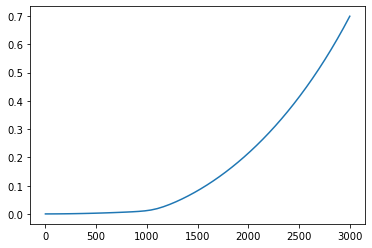

In [69]:
plt.plot(y_grid, h_grid[25])

In [65]:
@njit(parallel=True)
def simulate_emission(e_grid, y_grid, y_start=290, z_loc=25, T=100):
    Et = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = np.interp(y_start, y_grid, e_grid[z_loc])
        y_start = y_start + Et[i]
    return Et


@njit(parallel=True)
def simulate_h(e_grid, y_grid, h_grid, y_start=290, z_loc=25, T=100):
    ht = np.zeros(T+1)
    for i in range(T+1):
        e = np.interp(y_start, y_grid, e_grid[z_loc])
        ht[i] = np.interp(y_start, y_grid, h_grid[z_loc])
        y_start = y_start + e
    return ht


@njit(parallel=True)
def simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=100_000, T=100, dt=1.):
    var_z = dt*σ_z@σ_z/(1-(1-β_z*dt)**2)
    std_z = np.sqrt(var_z)

    time_periods = int(T/dt)
    z_path = np.zeros((N, time_periods+1))
    k_path = np.zeros((N, time_periods+1))
    for i in range(N):
        z0 = np.random.normal(0.,std_z)
        k0 = k_start
        z_path[i, 0] = z0
        k_path[i, 0] = k0
        for j in range(1, time_periods+1):
            k1 = k0 + (α_k + β_k*z0 + ioverk - κ/2.*ioverk**2 - σ_k@σ_k/2.)*dt + σ_k@Ws[i, j]*np.sqrt(dt)
            z1 = (1.-β_z*dt)*z0 + σ_z@Ws[i, j]*np.sqrt(dt)
            k_path[i, j] = k1
            z_path[i, j] = z1
            k0 = k1
            z0 = z1
    return k_path

In [66]:
# np.save('phi_grid.npy', ϕ_grid)
# np.save('emission_grid.npy', e_grid)

In [67]:
T = 100
Et = simulate_emission(e_grid, y_grid, y_start=290, z_loc=25, T=T)
ht = simulate_h(e_grid, y_grid, h_grid, y_start=290, z_loc=25, T=T)

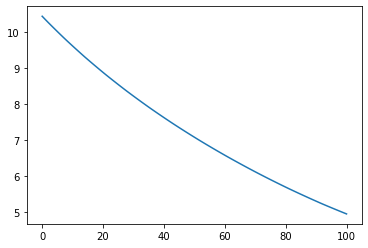

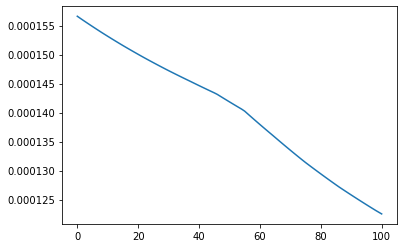

In [68]:
plt.plot(Et)
plt.figure()
plt.plot(ht)

In [ ]:
T = 100
N = 1_000_000
dt = 1.
k_start = np.log(80/α)
Ws = np.random.multivariate_normal(np.zeros(2), np.eye(2), (N, int(T/dt)))
logk_path = simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=N, T=T, dt=dt)
Kt = np.percentile(np.exp(logk_path), 50, axis=0)

In [ ]:
SCCt = η*(α-ioverk)*Kt/((1.-η)*Et)
# SCCt = η*(0.025)*Kt/((1.-η)*Et)

In [ ]:
plt.plot(SCCt[:21]*1000)
plt.ylim(0, None)
plt.title('Figure 1: Social cost of carbon')
plt.xlabel('Year')
# plt.savefig('figure_1.pdf')

In [ ]:
import pickle
with open('scc_bhh.pkl', 'rb') as f:
    scc_bhh = pickle.load(f)
with open('emission.pkl', 'rb') as f:
    emission_bbh = pickle.load(f)

In [ ]:
plt.plot(scc_bhh[0]['x'], scc_bhh[0]['y'])

In [ ]:
scc_low = np.array([scc_bhh[0]['y'][4*i] for i in range(21)])

### SCC formula

$$
SCC = \frac{\eta\left[\color{red}{\alpha - \left(\frac{i}{k}\right)^*}\right]K_t^*}{(1-\eta)E_t^*}
$$

(1) in BBH, $\alpha=0.115, \left(\frac{i}{k}\right)^*=0.09$, so $\left[\alpha - \left(\frac{i}{k}\right)^*\right]=0.025$.

(2) in the new paper, $\alpha=0.2, \left(\frac{i}{k}\right)^*=0.125$, so $\left[\alpha - \left(\frac{i}{k}\right)^*\right]=0.075$.

### Adjustment cost parameters

$\alpha=0.115, \left(\frac{i}{k}\right)^*=0.09$

From FOC of $\frac{i}{k}$, we have:
$$
1-\kappa \left(\frac{i}{k}\right)^* - \frac{\delta}{\alpha-\left(\frac{i}{k}\right)^*} = 0 
$$

Therefore $\kappa=6.667$

### Log damage evolution

$$
d\log N_t = \left[\frac{d}{d\tau}\Lambda(Z_{2,t} F_t)[E_tZ_t-\rho(Z_{2,t}-\mu_2)F_t]+\frac{1}{2}\frac{d^2}{d\tau^2}\Lambda(Z_{2,t}F_t)Z_{2,t}F_t^2\sigma_2^2\right]dt + \frac{d}{d\tau} \Lambda(Z_{2,t}F_t)F_t\sqrt{Z_{2,t}}\sigma_zdW_t
$$

where

$$
dZ_t^2 = -\rho(Z_t^2 - \mu_2) dt + \sqrt{Z_t^2}\sigma_2 d W_{2,t}
$$

$$
\Lambda(\tau) = \lambda_1 \tau + \frac{\lambda_2}{2} \tau^2
$$

In [ ]:
(1-δ/(α-ioverk))/ioverk

In [ ]:
-0.0429 + ioverk - κ/2.*ioverk**2

In [ ]:
plt.plot(SCCt[:21]*1000, label='new')
plt.plot(scc_low, label='BBH low damage')
plt.ylim(0, 150)
plt.xlabel('Year')
plt.legend()
plt.title('SCC comparison')
plt.savefig('scc.pdf')

In [ ]:
plt.plot(Et[:21], label='new')
plt.plot(emission_low, label='BBH low damage')
plt.ylim(0, 20)
plt.xlabel('Year')
plt.legend()
plt.title('Emission comparison')
plt.savefig('emission.pdf')

In [ ]:
emission_low = np.array([emission_bbh[0]['y'][4*i] for i in range(21)])